In [1]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.inspection import PartialDependenceDisplay

import biomassml
from biomassml.feature_importance import *
from biomassml.predict_outputs import *

DATA_DIR = '.../data'

feature_names = ['SA', 'SBR', 'HHVbiom', 'T', 'SR', 'C', 'H', 'O', 'ash', 'VM', 'FC', 'MC']
output_names = ['CO (vol%)', r'H$_2$ (vol%)', 'COMBgas (vol%)', r'GAS (m$^3$/kg biom)', r'CH$_4$ (vol%)']

### load GASIF dataset

In [3]:
dfGASIF_dataset = pd.read_csv(os.path.join(DATA_DIR, 'data_GASIF_biomass.csv'))

In [4]:
dfGASIF_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BIOMASS           30 non-null     object 
 1   SA                30 non-null     float64
 2   SBR               30 non-null     float64
 3   HHVbiom (MJ/kg)   30 non-null     float64
 4   T (K)             30 non-null     int64  
 5   SR                30 non-null     float64
 6   C (%)             30 non-null     float64
 7   N (%)             30 non-null     float64
 8   H (%)             30 non-null     float64
 9   S (%)             30 non-null     float64
 10  O (%)             30 non-null     float64
 11  ash (%)           30 non-null     float64
 12  VM (%)            30 non-null     float64
 13  FC (%)            30 non-null     float64
 14  MC (%)            30 non-null     float64
 15  volCO2 (%)        30 non-null     float64
 16  volCO (%)         30 non-null     float64
 17 

In [5]:
FEATURES_GASIF = pd.concat([dfGASIF_dataset.iloc[:,1:7], dfGASIF_dataset.iloc[:,[8,10,11,12,13,14]]], axis=1)
FEATURES_GASIF.head(1)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC (%)
0,2.33,1.1,19.5649,1173,0.13,49.44,5.85,42.9,1.45,78.93,19.62,6.52


In [6]:
TARGETS_GASIF = dfGASIF_dataset.iloc[:,[16,18,19,20]]
TARGETS_GASIF.head(1)

,volCO (%),volH2 (%),volCOMB (%),GAS (m3/kg biom)
0,23.6541,36.4296,67.4756,0.7975


In [7]:
features = list(FEATURES_GASIF.columns)

#### get scalers from dfGASIF_dataset

In [8]:
x_scaler, y_scaler = get_scalers(FEATURES_GASIF, TARGETS_GASIF)
joblib.dump(x_scaler, 'x_scaler')
joblib.dump(y_scaler, 'y_scaler')

['y_scaler']

### load model

In [9]:
model = joblib.load('model_12in4out')

### partial dependence plots

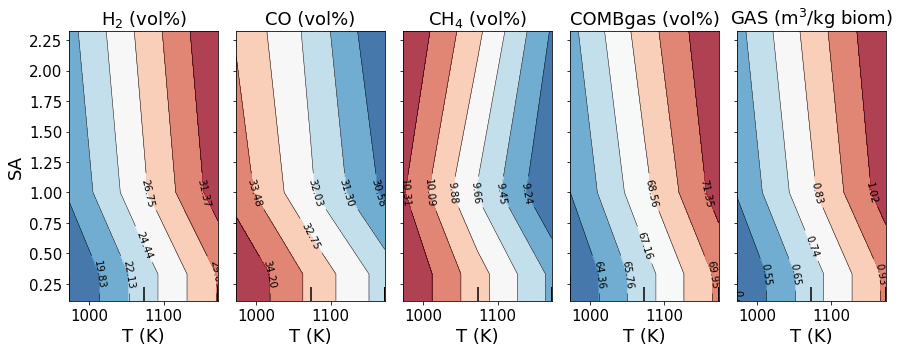

In [10]:
featureX=3
featureY=0  
featuresXY=[(featureX, featureY)]
model_CO = GPYEstimator(model, 0, x_scaler, y_scaler)
model_H2 = GPYEstimator(model, 1, x_scaler, y_scaler)
model_CH4 = GPY_CH4_Estimator(model, x_scaler, y_scaler)
model_COMB = GPYEstimator(model, 2, x_scaler, y_scaler)
model_GAS = GPYEstimator(model, 3, x_scaler, y_scaler)
contour_kw = {
    'cmap': 'RdBu_r',
    'alpha': 0.8,
}
fig, ax = plt.subplots(1, 5, figsize=(12.5,5), sharey=True)

PartialDependenceDisplay.from_estimator(estimator=model_H2, X=FEATURES_GASIF, features=featuresXY, ax=[ax[0]], 
                                        contour_kw=contour_kw)
ax[0].set_title(output_names[1], fontsize=18)
ax[0].yaxis.label.set_size(18)
ax[0].xaxis.label.set_size(18)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

PartialDependenceDisplay.from_estimator(estimator=model_CO, X=FEATURES_GASIF, features=featuresXY, ax=[ax[1]], 
                                        contour_kw=contour_kw)
ax[1].set_title(output_names[0], fontsize=18)
ax[1].set_ylabel(None)
ax[1].xaxis.label.set_size(18)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)

PartialDependenceDisplay.from_estimator(estimator=model_CH4, X=FEATURES_GASIF, features=featuresXY, ax=[ax[2]], 
                                        contour_kw=contour_kw)
ax[2].set_title(output_names[4], fontsize=18)
ax[2].set_ylabel(None)
ax[2].xaxis.label.set_size(18)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)

PartialDependenceDisplay.from_estimator(estimator=model_COMB, X=FEATURES_GASIF, features=featuresXY, ax=[ax[3]], 
                                        contour_kw=contour_kw)
ax[3].set_title(output_names[2], fontsize=18)
ax[3].set_ylabel(None)
ax[3].xaxis.label.set_size(18)
ax[3].xaxis.set_tick_params(labelsize=15)
ax[3].yaxis.set_tick_params(labelsize=15)

PartialDependenceDisplay.from_estimator(estimator=model_GAS, X=FEATURES_GASIF, features=featuresXY, ax=[ax[4]], 
                                        contour_kw=contour_kw)
ax[4].set_title(output_names[3], fontsize=18)
ax[4].set_ylabel(None)
ax[4].xaxis.label.set_size(18)
ax[4].xaxis.set_tick_params(labelsize=15)
ax[4].yaxis.set_tick_params(labelsize=15)

fig.tight_layout(w_pad=1.5)
plt.show()

### SHAP plots

In [11]:
def plot_shap(shap_values, X, feature_names, output_names, n_output):
    colors = ['darkred', 'darkred', '#1a5899', 'darkred', 'darkred',
              '#1a5899','#1a5899', '#1a5899','#1a5899', '#1a5899', '#1a5899', '#1a5899']
    features_ind = np.argsort([-np.abs(shap_values[:,i]).mean() for i in range(shap_values.shape[1])])
    colors = np.array(colors)[features_ind]
    shap.summary_plot(shap_values=shap_values,
                      features=X, 
                      feature_names = feature_names,
                      max_display=12, plot_type='dot', plot_size=(4.5,4.5),
                      show=False, cmap='RdBu_r', color_bar_label='feature value')
    plt.title(output_names[n_output], fontsize=18)
    plt.gcf().axes[-1].set_aspect('auto')
    plt.gcf().axes[-1].set_box_aspect(30)
    plt.gca().tick_params(labelsize=14.5, labelcolor='dimgray')
    for i in np.arange(len(colors))+1:
        plt.gca().get_yticklabels()[i-1].set_color(colors[-i])
    plt.xlabel('-       SHAP value       +')
    plt.xticks(ticks=())
    plt.tight_layout()
    plt.show()

In [12]:
n_output=0
shap_values_CO = get_shap_values(model, FEATURES_GASIF, x_scaler, y_scaler, index=n_output,
                                 custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

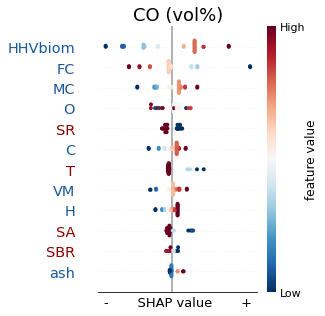

In [13]:
plot_shap(shap_values_CO, FEATURES_GASIF, feature_names, output_names, 0)

In [14]:
n_output=1
shap_values_H2 = get_shap_values(model, FEATURES_GASIF, x_scaler, y_scaler, index=n_output,
                                 custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

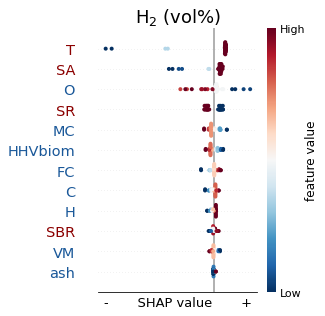

In [15]:
plot_shap(shap_values_H2, FEATURES_GASIF, feature_names, output_names, 1)

In [16]:
n_output=2
shap_values_COMB = get_shap_values(model, FEATURES_GASIF, x_scaler, y_scaler, index=n_output,
                                   custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

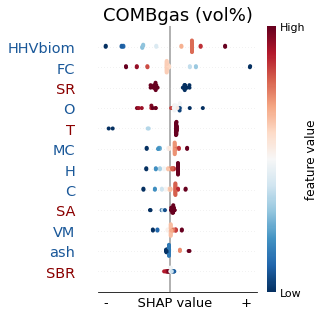

In [17]:
plot_shap(shap_values_COMB, FEATURES_GASIF, feature_names, output_names, 2)

In [18]:
n_output=3
shap_values_GAS = get_shap_values(model, FEATURES_GASIF, x_scaler, y_scaler, index=n_output,
                                  custom_wrapper=None, coregionalized=True)

  0%|          | 0/30 [00:00<?, ?it/s]

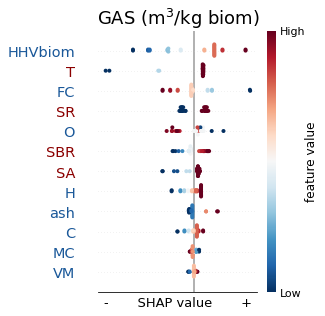

In [19]:
plot_shap(shap_values_GAS, FEATURES_GASIF, feature_names, output_names, 3)

In [20]:
shap_values_CH4 = get_shap_values(model, FEATURES_GASIF, x_scaler, y_scaler,
                                  custom_wrapper=custom_wrapper_CH4)

  0%|          | 0/30 [00:00<?, ?it/s]

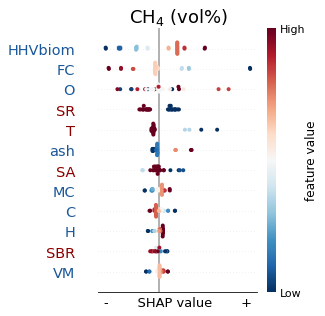

In [21]:
plot_shap(shap_values_CH4, FEATURES_GASIF, feature_names, output_names, 4)